In [2]:
#### Rama projektowa - Opisywanie obrazów z wykorzystaniem głębokiego uczenia
#### autorzy: Anna Konieczna, Mateusz Ostrowski

### Rama projektowa
Tutorial: https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8 <br>
Zbiór danych: <br>
#### Opis:  <br>


In [42]:
#### Config
config = { "images_path": "../Flickr8k_Dataset/",
           "train_images_path": "../Flickr8k_text/Flickr_8k.trainImages.txt", # file conatains the names of images to be used in train data
           "test_images_path": "../Flickr8k_text/Flickr_8k.testImages.txt",
           "train_path": "../Flickr8k_text/Flickr_8k.trainImages.txt", 
           "token_path": "../Flickr8k_text/Flickr8k.token.txt",
           "word_embedings_path": "../glove/glove.6B.200d.txt",
           "embedings_dim": 200, # Polish - 100
           "train_model": False, # True if you intend to train the model
           "encode_images": False,
           "pretrained_model_path": "",
           "encoded_images_test": "../Pickle/encoded_test_images.pkl",
           "encoded_images_train": "../Pickle/encoded_train_images.pkl",
           "report_path": "",
           "preprocessed_descriptions_save_path": "descriptions.txt",
           "use_lemma": False,
           "spacy_lemma_model": "pl_spacy_model",
           "lstm_model_save_dir": "../model_weights/",
           "lstm_model_save_path": "../model_weights/model_30.h5"}

In [7]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from nltk.translate.meteor_score import meteor_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [8]:
# Load the description set

def load_doc(filename):
	file = open(filename, 'r')
	text = file.read()
	file.close()
	return text

filename = config["token_path"]
# załaduj opisy
doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the s


In [9]:
# Load the descriptions to dict structure

def load_descriptions(doc):
	mapping = dict()
	for line in doc.split('\n'):
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


In [10]:
if config["use_lemma"]:
    import spacy
    nlp = spacy.load('pl_spacy_model')

def clean_descriptions(descriptions):
  # prepare translation table for removing punctuation
  table = str.maketrans('', '', string.punctuation)
  for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
      desc = desc_list[i]
      if config["use_lemma"]:
          doc = nlp(desc)
      # tokenize
      desc = desc.split()
      # convert to lower case
      desc = [word.lower() for word in desc]
# Lematyzacja
#### spacy model from here: http://zil.ipipan.waw.pl/SpacyPL?action=AttachFile&do=view&target=pl_spacy_model-0.1.0.tar.gz
#### spacy dokumentacja - https://spacy.io/usage
      if config["use_lemma"]:
          desc = [word.lemma_ for word in doc]
      # remove punctuation from each token
      desc = [w.translate(table) for w in desc]
      # remove tokens with numbers in them
      desc = [word for word in desc if word.isalpha()]
      # store as string
      desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8775


In [12]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, config["preprocessed_descriptions_save_path"])

In [13]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = config["train_path"]
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [14]:
# Below path contains all the images
images = config["images_path"]
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [15]:
# Read the train image names in a set
train_images = set(open(config["train_images_path"], 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

In [16]:
# Below file conatains the names of images to be used in test data
test_images_file = config["test_images_path"]
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

In [17]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions(config["preprocessed_descriptions_save_path"], train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [18]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [19]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [20]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [18]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [22]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
if config["encode_images"]:
    start = time()
    encoding_train = {}
    for img in train_img:
        encoding_train[img[len(images):]] = encode(img)
        print('.', end='')
    print("Time taken in seconds =", time()-start)

In [23]:
import os
import pickle

if config["encode_images"]:
    mode = 'a' if os.path.exists(config["encoded_images_train"]) else 'wb'

    # Save the bottleneck train features to disk
    with open(config["encoded_images_train"], "wb") as encoded_pickle:
        pickle.dump(encoding_train, encoded_pickle)

In [24]:
# Call the funtion to encode all the test images - Execute this only once
if config["encode_images"]:
    start = time()
    encoding_test = {}
    for img in test_img:
        encoding_test[img[len(images):]] = encode(img)
        print('.', end='')
    print("Time taken in seconds =", time()-start)

In [25]:
# Save the bottleneck test features to disk
if config["encode_images"]:
    with open(config["encoded_images_test"], "wb") as encoded_pickle:
        pickle.dump(encoding_test, encoded_pickle)

In [26]:
with open(config["encoded_images_train"], "rb") as encoded_pickle:
    encoding_train = load(encoded_pickle)
with open(config["encoded_images_test"], "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [27]:
train_features = load(open(config["encoded_images_train"], "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [28]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [29]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7589 -> 1654


In [30]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [31]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1655

In [32]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 37


In [33]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
#                 yield [[array(X1), array(X2)], array(y)]
                yield ([array(X1), array(X2)], array(y)) 
                X1, X2, y = list(), list(), list()
                n=0

In [34]:
# Load Glove vectors

embeddings_index = {} # empty dictionary

f = open(config["word_embedings_path"], encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [35]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, config["embedings_dim"]))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [36]:
embedding_matrix.shape

(1655, 200)

In [37]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, config["embedings_dim"], mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [38]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      331000      input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_2[0][0]                    
_______________________________________________________________________________________

In [39]:
model.layers[2]

In [40]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [43]:
if config["train_model"]:
    epochs = 10
    number_pics_per_bath = 3
    steps = len(train_descriptions)//number_pics_per_bath

In [44]:
if config["train_model"]:
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        writepath = config["lstm_model_save_dir"] + 'model_' + str(i) + '.h5'
        mode = 'a' if os.path.exists(writepath) else 'wb'
        model.save(writepath)

In [45]:
# model.optimizer.lr = 0.0001
if config["train_model"]:
    epochs = 10
    number_pics_per_bath = 6
    steps = len(train_descriptions)//number_pics_per_bath

In [46]:
if config["train_model"]:
    for i in range(epochs):
        generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
        model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
        #model.save('./model_weights/model_' + str(i) + '.h5')

In [47]:
if config["train_model"]:
    model.save_weights(config["lstm_model_save_path"])

In [48]:
model.load_weights(config["lstm_model_save_path"])

In [49]:
images = config["images_path"]

In [50]:
with open(config["encoded_images_test"], "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [51]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

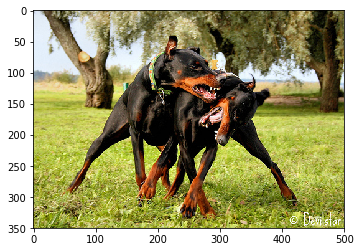

Greedy: a black dog is running through the grass
['two dobermans fighting or playing together on a lawn', 'two dogs fight on the grass', 'two dogs play together', 'two dogs wrestle in the grass', 'two large dogs are fighting with teeth bared near some trees']


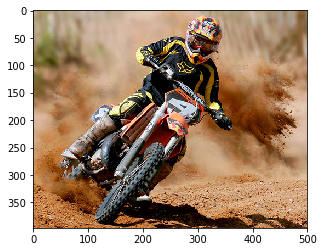

Greedy: a man on a bike is riding a bike in the woods
['a dirt biker turns across the dirt', 'a dirt bike takes a turn', 'a man riding a motorbike kicks up dirt', 'a person rides a dirt bike', 'the motorcycle racer is taking a curve on the dirt track']


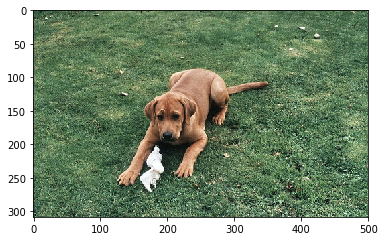

Greedy: a brown dog is running through the grass
['a brown dog laying in the grass with a white chew toy', 'a brown dog lying in the grass playing with a white rag', 'a brown dog sitting on grass', 'a dog sitting on grass', 'orange dog with knotted white rag on grass']


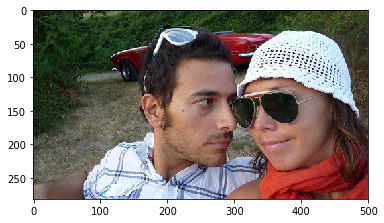

Greedy: a man with a beard and a hat is smiling
['a couple practice different ways to wear sunglasses in front of a red car', 'a girl and boy with sunglasses and a red car behind them', 'a man with sunglasses and a woman with a hat are in front of a car', 'a man with sunglasses on his head is looking at the woman with a white hat and red scarf next to him whilst standing in front of a red sports car', 'a woman in a crochet hat and sunglasses smiles while the man beside her in a plaid short and sunglasses looks behind her']


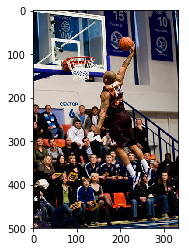

Greedy: a group of young men are playing basketball on a court
['a bald man is attempting to slam dunk a basketball in a game while people in the stands watch', 'a basketball player is jumping and about to dunk a ball in front of a crowd', 'a man reaches toward dunking a basketball while an audience watches', 'a tattooed man dunks a basketball', 'the tattooed basketball player is about to dunk the ball']


In [52]:
for i in range(0,5):
    pic = list(encoding_test.keys())[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))
    print(descriptions[pic[:-4]])

In [53]:
#### Metrics
##### Cider
#function for calculating cider metric
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cider(given_captions, prediction):
    prediction_arr = []
    prediction_arr.append(prediction)
    vectorizer = TfidfVectorizer()
    trainedV = vectorizer.fit(given_captions)
    givenTfIdf = trainedV.transform(given_captions).toarray()
    predTfIdf = trainedV.transform(prediction_arr).toarray()
    partialCiders = 0
    help_arr = []
    
    for c in givenTfIdf:
        help_arr.append(c)
        partialCiders = partialCiders + cosine_similarity(predTfIdf,help_arr)
        help_arr = []
        
    return partialCiders/len(givenTfIdf)

In [57]:
#### 
import warnings; warnings.simplefilter('ignore')
from IPython.display import clear_output

#preparation of metrics lists
bleu_train_scores = []
meteor_train_scores = []
cider_train_scores = []
    
for i in range(0,5):
    bleu_train_scores.append([])
    meteor_train_scores.append([])
    cider_train_scores.append([])
    
    train_pics = list(encoding_train.keys())

    #calculation of metrics for train images dataset
    for j in range(0,len(train_pics)):
        pic = train_pics[j]
        image = encoding_train[pic].reshape((1,2048))

        actual_desc_0 = descriptions[pic.rsplit( ".", 1 )[ 0 ]][0]
        actual_desc_1 = descriptions[pic.rsplit( ".", 1 )[ 0 ]][1]
        generated = greedySearch(image)
        bleu_train_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_train_scores[i].append(meteor_score(descriptions[pic.split('.')[0]],generated))
        cider_train_scores[i].append(cider(descriptions[pic.split('.')[0]],generated)[0][0])

        clear_output(wait=True)
        print('train',i,j, flush=True)

result_data = {}

#calculate mean score based on socres list for each metric
for i in range(0,5):
    result_data[str(i)] = [
        mean(bleu_train_scores[i]),
        mean(meteor_train_scores[i]),
        mean(cider_train_scores[i]),
    ]

result = pd.DataFrame.from_dict(
    result_data,
    orient='index',
    columns=['Bleu TREN', 'Bleu TEST', 'Meteor TREN', 'Meteor TEST', 'CIDEr TREN', 'CIDEr TEST']
)

result

train 0 5999


NameError: name 'description' is not defined

In [58]:
 for i in range(0,5):

    bleu_test_scores.append([])
    meteor_test_scores.append([])
    cider_test_scores.append([])
    test_pics = list(encoding_test.keys())

    #calculation of metrics for test images dataset
    for j in range(0,len(test_pics)):
        pic = test_pics[j]
        image = encoding_test[pic].reshape((1,2048))

        actual_desc_0 = descriptions[pic.rsplit( ".", 1 )[ 0 ]][0]
        actual_desc_1 = descriptions[pic.rsplit( ".", 1 )[ 0 ]][1]
        generated = greedySearch(image)
        bleu_test_scores[i].append(
            sentence_bleu(
                [actual_desc_0.split(), actual_desc_1.split()],
                generated.split())
        )
        meteor_test_scores[i].append(meteor_score(descriptions[pic.split('.')[0]],generated))
        cider_test_scores[i].append(cider(descriptions[pic.split('.')[0]],generated)[0][0])

        clear_output(wait=True)
        print('test',i,j, flush=True)


result_data = {}

#calculate mean score based on socres list for each metric
for i in range(0,5):
    result_data[str(i)] = [
        mean(bleu_test_scores[i]),
        mean(meteor_test_scores[i]),
        mean(cider_test_scores[i])
    ]

result = pd.DataFrame.from_dict(
    result_data,
    orient='index',
    columns=['Bleu TREN', 'Bleu TEST', 'Meteor TREN', 'Meteor TEST', 'CIDEr TREN', 'CIDEr TEST']
)

result

test 4 999


NameError: name 'mean' is not defined

In [59]:
#calculate mean score based on socres list for each metric
from numpy import mean

for i in range(0,5):
    result_data[str(i)] = [
        mean(bleu_test_scores[i]),
        mean(meteor_test_scores[i]),
        mean(cider_test_scores[i])
    ]

result = pd.DataFrame.from_dict(
    result_data,
    orient='index',
    columns=['Bleu', 'Meteor TREN', 'Meteor TEST', 'CIDEr TREN', 'CIDEr TEST']
)

result

ValueError: 6 columns passed, passed data had 3 columns